# ***L01:*** Partial Dependency (PDP) and Individual Conditional Expectation (ICE) Plots

<img src="./static/LO1.png" alt="LO1 Image" style="width: 50%; height: auto;">

In this notebook, you will explore the utility and limitations of Partial Dependency (PDP) and Individual Conditional Expectation (ICE) plots. You have two pairs of datasets and models to work with.

The first pair consists of a bike rental dataset (bike_sharing_data.csv) and its corresponding model (bike_sharing_model.pkl). This dataset includes four features: temp, feel_temp, humidity, and windspeed, each of which affects the number of bike rentals differently. In Section 1, you will test your understanding of PDP and ICE concepts by generating your own code to replicate the results from sklearn's built-in PDP and ICE plotting functions.

The second pair is a mystery dataset (mystery_data.csv) and its model (mystery_model.pkl). The mystery dataset contains only two binary features. In Section 2, you will analyze this dataset and try to determine the model's decision-making process. It is important to note that the mystery model has a 100% classification accuracy.

-------------------------

### Section 1 | Understand PDP and ICE curves by replicating sklearn plots with your own code

- 1.1 | Manually compute the PDP curve for the target feature "temp" and plot the result  
- 1.2 | Manually compute the ICE curves for the target feature of "temp" and plot the results    
- 1.3 | Center the ICE curves and plot the results as well as the average on the same axes  
- 1.4 | Discuss your results  

### Section 2 | Try and determine what rule the mystery model is using for its predictions on the mystery dataset  

- 2.1 | Plot the PDP and ICE curves for both "Feature1" and "Feature2"  
- 2.2 | Analyze and discuss the results. If you cannot explain the model's decisions, then argue your point.  

-----------------------

Import necessary libraries

In [5]:
import joblib # for saving and loading models from sklearn
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for data visualization
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay # for displaying partial dependence plots and individual conditional expectation
import warnings # filter warnings
warnings.filterwarnings("ignore")

Import the model and data

In [6]:
model = joblib.load('../models/bike_sharing_model.pkl')
data = pd.read_csv('../data/bike_sharing_data.csv')

Use sklearn's built-in function to plot the ICE and PDP

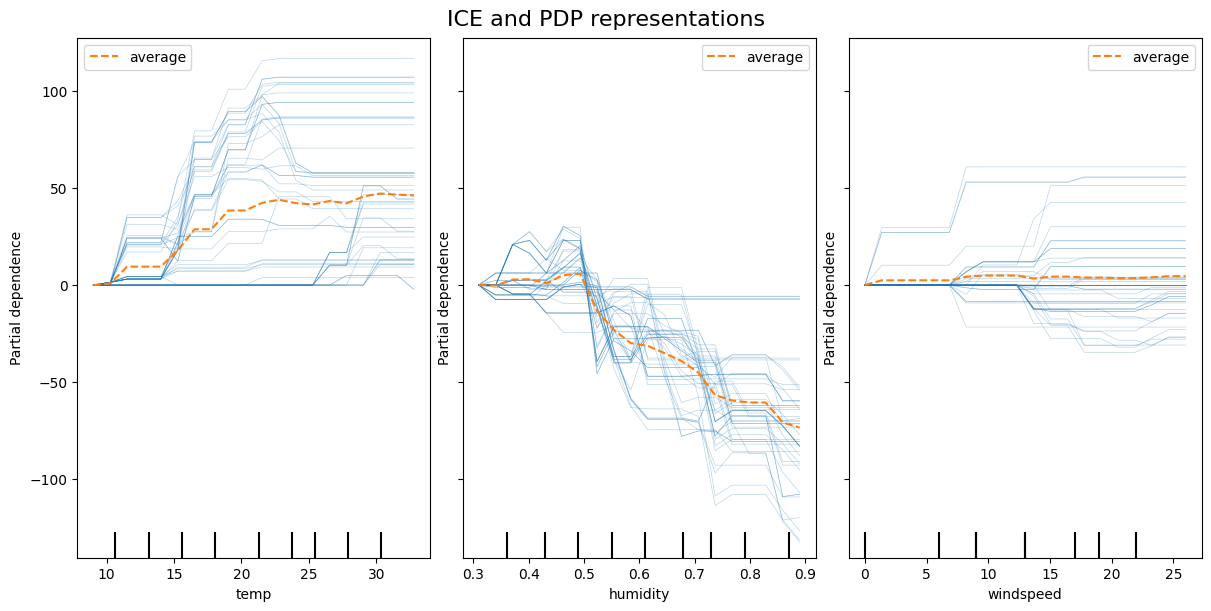

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True, constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model, # Pre-trained gradient boosed regressor tree model
    data, # Data to plot
    features=["temp", "humidity", "windspeed"], # Features to plot from the dataframe
    kind="both",  # This will plot both PDP and ICE
    centered=True, # Center the ICE curves becaue we are only interested in the shape of the curve not the absolute values
    subsample=50, # Subsample the data to speed up the plotting, we only plot 50 instances
    n_jobs=2, # Use 2 cores to speed up the computation
    grid_resolution=20, # Number of points in the grid, the higher the better the resolution
    random_state=0, # Set the random state for reproducibility
    ax=ax) # Plot the ICE and PDP on the same axis
display.figure_.suptitle("ICE and PDP representations", fontsize=16) # Set the title of the plot
plt.show() # Show the plot
plt.close() # Close the plot to free up memory

### Section 1 | Understand PDP and ICE curves by replicating sklearn plots with your own code


Using your theoretical knowledge from LO1, your task is to manually calculate both the PDP and ICE curves. For this, you will only require the **model** and **data** loaded above. The data is stored in a pandas dataframe, and the model is a pre-trained tree regression model. You can view the dataframe's first few entries using the method `data.head()`. Remember to vectorize your code; you should only ever require a single for loop and never a nested loop.

**1.1 | Manually compute the PDP curve for the target feature "temp" and plot the result**

Remember: The PDP formula, $f_{PDP}^p(x^p) = \mathbb{E}_{X_{-p}}[f(x^1, x^2, \ldots, x^p, \ldots, x^k)]$, calculates the marginal effect of the feature $x^p$ on the predicted outcome by averaging the predictions of the function $f$ over the joint distribution of all other features $X_{-p}$. Remember to sort the dataset according to the temp value before calculating and plotting.

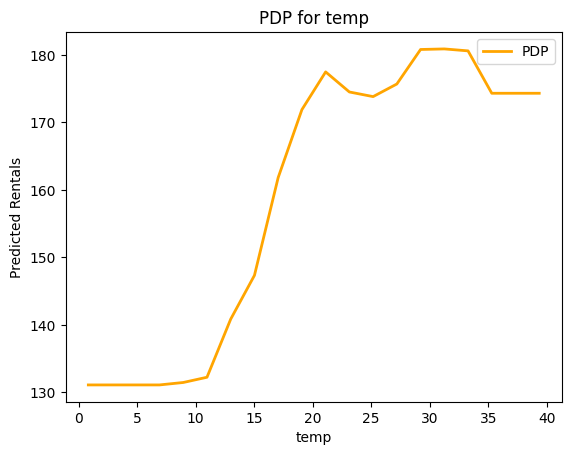

In [8]:
# YOUR CODE HERE
def plot_pdp(data, model, feature):
    min_temp = data[feature].min()
    max_temp = data[feature].max()
    feature_values = np.linspace(min_temp, max_temp, num=20)  # Ensure the same grid resolution

    data_subsampled = data.sample(n=50, random_state=0) # Matching the subsample size to the sklearn example
    pdp_curve = []

    for temp in feature_values:
        data_feature = data_subsampled.copy()
        data_feature[feature] = temp
        pdp_curve.append(model.predict(data_feature).mean())

    plt.plot(feature_values, pdp_curve, color='orange', label='PDP', linewidth=2)
    plt.xlabel(f'{feature}')
    plt.ylabel('Predicted Rentals')
    plt.title(f'PDP for {feature}')
    plt.legend()
    plt.show()

plot_pdp(data, model, 'temp')

Note that the PDP curve is not centered, as I did not center the ICE curves, and thus the values go up to 180 and represent actua rental value predictions, instead of relative changes.

***1.2 | Manually compute the ICE curves for the target feature of temp and plot the results***

Remember, a single ICE curve consists of the model predictions over a fixed instance while varying the feature of interest. It is extremely computationally expensive to calculate ICE curves for all instances, therefore randomly sample and plot the ICEs of 50 instances only.

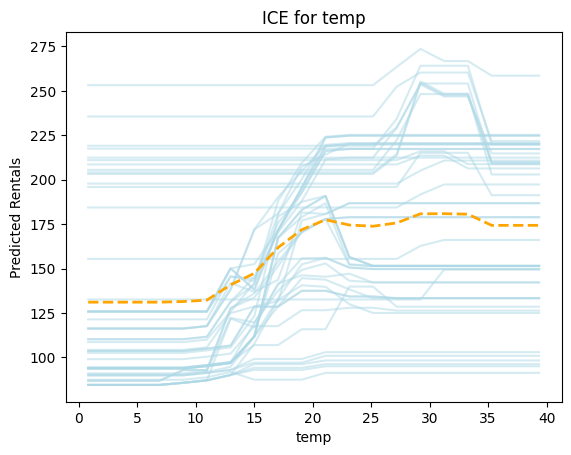

In [9]:
# YOUR CODE HERE
def plot_ice(data, model, feature, centered=False, pdp=False):
    min_temp = data[feature].min()
    max_temp = data[feature].max()
    feature_values = np.linspace(min_temp, max_temp, num=20)  # Ensure the same grid resolution

    data_subsampled = data.sample(n=50, random_state=0) # Matching the subsample size to the sklearn example
    ice_curves = []

    # Calculate baseline prediction at the smallest feature value (min_temp)
    data_baseline = data_subsampled.copy()
    data_baseline[feature] = min_temp  # Anchor at the minimum feature value
    baseline_predictions = model.predict(data_baseline)

    for temp in feature_values:
        data_feature = data_subsampled.copy()
        data_feature[feature] = temp  # Set current feature value for all instances
        predictions = model.predict(data_feature)
        ice_curve = predictions - baseline_predictions if centered else predictions
        ice_curves.append(ice_curve)

    # Convert ice_curves from a list of predictions to a 2D array (one curve per row)
    ice_curves = np.array(ice_curves).T

    # Plot ICE curves
    for ice_curve in ice_curves:
        plt.plot(feature_values, ice_curve, color='lightblue', alpha=0.5)  # Plot each ICE curve

    # Calculate and plot the average of the ICE curves (i.e., the centered PDP)
    if pdp:
        avg_curve = np.mean(ice_curves, axis=0)
        plt.plot(feature_values, avg_curve, color='orange', label='Average (PDP)', linewidth=2, linestyle='--')

    plt.xlabel(f'{feature}')
    plt.ylabel('Predicted Rentals' if not centered else 'Relative Predicted Rentals')
    plt.title(f'ICE for {feature}')
    plt.show()

plot_ice(data, model, 'temp', centered=False, pdp=True)

***1.3 | Center the ICE curves and plot the results as well as the average on the same axes***

It is often difficult to interpret ICEs because the plot is unorderly. Since we are only interested in trends and not absolute values, i.e., does the predicted target increase, decrease, or remain the same as we vary the input. One way to center the ICE is to subtract a constant baseline. Selecting the baseline as the predicted value when selecting the anchor as the smallest feature value will ensure all ICE curves start from zero.

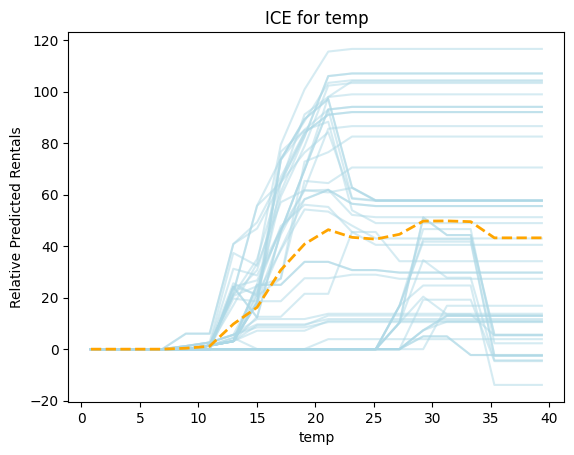

In [10]:
# YOUR CODE HERE
plot_ice(data, model, 'temp', centered=True, pdp=True)

***1.4 | Discuss your results***

In [11]:
# YOUR ANSWER HERE

### Section 2 | Try and determine what rule the mystery model is using for its predictions on the mystery dataset

***2.1 | Plot the PDP and ICE curves for both "Feature1" and "Feature2"***

In [12]:
import sys
import struct

print(sys.version)
print(f"Python is {8 * struct.calcsize('P')} bits")

3.10.15 | packaged by conda-forge | (main, Sep 20 2024, 16:34:16) [Clang 17.0.6 ]
Python is 64 bits


TODO: Check with Brandon, probably fails because model saved differently?

In [13]:
import xgboost as xgb
import os

# Import mystery data and model
model_path = '../models/mystery_model.pkl'
print(f"Model file exists: {os.path.exists(model_path)}")
print(f"Model file size: {os.path.getsize(model_path) / (1024 * 1024):.2f} MB")

model = xgb.Booster()
model.load_model(model_path)

X = pd.read_csv('../data/mystery_data.csv')
X.head()

Model file exists: True
Model file size: 0.02 MB


XGBoostError: std::bad_alloc

In [11]:
# YOUR CODE HERE
plot_ice(X, model, 'Feature1', centered=True, pdp=True)
plot_ice(X, model, 'Feature2', centered=True, pdp=True)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

***2.2 | Analyze and discuss the results. If you cannot explain the model's decisions, then argue your point.***

In [ ]:
# YOUR ANSWER HERE

# ***L01:*** Shapley Vlaues (Theory and Application)

<img src="./static/SHAP.png" width="1500" alt="image description">

## Introduction
In this notebook, we will test both your understanding of the theory of Shapley values and your ability to interpret the results. The first task should allow you to better understand the principle equation of Shapley values

$$ 
\phi_i(x)=\sum_{S \subseteq N \backslash\{i\}} \frac{|S|!\times(|N|-|S|-1)!}{|N|!}\left(f_\theta(S \cup\{i\})-f_\theta(S)\right),
$$

and how they are calculated. You should be led to an understanding of the computational complexities involved in Shapley value calculations. You will then code your own approximate solution to the Shapley value problem and compare the results to the SHAP library.

## Using the SHAP Library
You will then use the SHAP library (https://shap.readthedocs.io/en/latest/index.html) to explain and interpret the predictions of two models. This library not only contains fast approximate methods such as KernelSHAP and TreeSHAP that you have encountered in the learning materials, but it also has built-in visualizations that can be used to interpret the results of the SHAP values. Visualizations include summary/beeswarm plots, dependence plots, force plots, and waterfall plots. These visualization tools allow you to analyze the impact of each feature on the output of the model at different levels of granularity. The plotting methods can be used to display both local explanations (per instance) and global explanations to say something meaningful about the features over the entire dataset.

## Datasets and Models
We will analyze two pairs of datasets and models.
1. **Titanic Dataset**: The first dataset is the Titanic dataset (`titanic_data.csv`), which contains information about the passengers on the Titanic. A tree ensemble model (`titanic_model.pkl`) was trained on the regression task of predicting whether a passenger survived or not.
2. **Mystery Dataset**: The second dataset is the mystery dataset and model from the last exercise (`mystery_data.csv`, `mystery_model.pkl`). 

You will use the SHAP library to enhance or resolve your arguments regarding the models' decision-making processes. Please note that the datasets do not contain the target values, however the targets were used to train the models.

------------
### Section 1 | Understanding the normalization factor in the Shapley value calculation    
- 1.1 Create a function in Python to calculate the weighting factor $\frac{|S|! \times (|N| - |S| - 1)!}{|N|!}$ in the Shapley value formula above. The function should take in two arguments, i.e., `shapley_weight_factor(n, s)` where $n$ is the total number of features and $s$ is the size of the subset. The function should output the weight assigned to each coalition of size $|S|$.
- 1.2 Use the function to sum the values of all possible coalitions and print your result.
- 1.3 Plot the number of combinations/coalitions as a function of subset size $|S|$. On the same axis, include a plot of the associated weight factor for each subset.
- 1.4 Explain why the weighting factor is necessary. Think about what kind of bias we could expect if we did not weight the values.

### Section 2 | Calculating Shapley values using Monte Carlo approximation 
- 2.1 If we want to calculate the Shapley values exactly for a single feature of a single instance/row, how many calculations have to be performed? Provide your reasoning and answer for the case of $n=4$ features.  
- 2.2 Approximate Calculation of Shapley Values Using Monte Carlo  

### Section 3 | Using the SHAP library to analyze the Titanic dataset

- 3.1 | Use the SHAP library to calculate the Shapley value for all features and instances of the Titianic dataset
- 3.2 | Identify and Rank the Importance of Each Feature for the Model's Decisions, Plot and Discuss the Results
- 3.4 | Compare a PDP plot for `Age` with a SHAP dependancy plot. What additional information do we gain?  
- 3.5 | Plot a SHAP feature dependence plot for 'Age' with interaction visualization for the passengers' Sex. Interpret the results
- 3.6 | Remove all the individual effects of the features and plot only the pure interaction between 'Age' and 'Class'
- 3.7 | Local Shapley Explanations

### Section 4 | Determine the decision making process of the mystery model
------------

Import necessary libraries

In [39]:
import shap # for calculating Shapley values using the SHAP library
import joblib # for saving and loading models from sklearn
import random # for generating random numbers
import numpy as np # for numerical operations
import pandas as pd # for tabular data manipulation
import xgboost as xgb # for training the XGBoost model
from math import factorial # for calculating the number of combinations
import matplotlib.pyplot as plt # for plotting
from itertools import combinations # for generating all possible combinations
import warnings
warnings.filterwarnings('ignore')
shap.initjs() # Visualize the SHAP values for the instance
# Create a color map
from matplotlib.colors import LinearSegmentedColormap
color_high = 'sandybrown'  # Color for high feature values
color_low = 'skyblue' # Color for low feature values
cmap = LinearSegmentedColormap.from_list("custom_cmap", [color_low, color_high])

### Section 1 | Understanding the Normalization Factor in the Shapley Value Calculation    

The image below depicts four hypothetical features representing a model's inputs. The colored shapes could represent class attendance, pre-exam results, hours of self-study, and age in a regression model trained to predict final exam results. Shapley values are calculated by computing and summing the model's output over all possible coalitions of features, with each result appropriately normalized. Here, we want to examine the normalization factor and how it relates to the total number of features and subset size. The image below shows all the possible coalitions if we were interested in calculating the contribution of the star to the model's output.

<img src="./static/shapley_weights.png" width="500" alt="image description">

**1.1 | Create a function in Python to calculate the weighting factor $\frac{|S|! \times (|N| - |S| - 1)!}{|N|!}$ in the Shapley value formula above. The function should take in two arguments, i.e., `shapley_weight_factor(n, s)` where $n$ is the total number of features and $s$ is the size of the subset. The function should output the weight assigned to each coalition of size $|S|$.**

In [40]:
from math import factorial, comb

def shapley_weight_factor(n, s):
    """
    Calculate the Shapley weight factor for a subset of size s with total n features.
    """
    # YOUR CODE HERE
    weight = factorial(abs(s)) * factorial(abs(n) - abs(s) - 1) / factorial(abs(n))
    print(weight, n, s)
    return weight

def number_of_combinations(n, s):
    """
    Calculate the number of combinations (subsets) of size s from a total of n features.
    """
    return comb(n, s)

***1.2 | Use the function to sum the values of all possible coalitions and print your result.***

In [41]:
# YOUR CODE HERE
import itertools

def all_subsets_except_i(N, i):
    """
    Generate all subsets of N \ {i}.
    N: Total set of features.
    i: The feature to exclude from subsets.
    """
    N_except_i = [x for x in N if x != i]
    subsets = []

    # Generate all possible subsets of N \ {i} using combinations
    for s in range(len(N_except_i) + 1):
        subsets.extend(itertools.combinations(N_except_i, s))
    return subsets

def f_theta(S):
    """
    Placeholder for the actual model function.
    For now, we can return something simple like the sum of the subset.
    """
    return sum(S)

def shapley_value_for_i(N, i):
    """
    Calculate the Shapley value for feature i given the set of all features N.
    """
    shapley_value = 0
    subsets = all_subsets_except_i(N, i)
    
    for S in subsets:
        s_size = len(S)
        weight = shapley_weight_factor(len(N), s_size)
        
        # Calculate the marginal contribution of i to the subset S
        S_with_i = set(S).union({i})
        marginal_contribution = f_theta(S_with_i) - f_theta(S)
        
        # Add the weighted marginal contribution to the Shapley value
        shapley_value += weight * marginal_contribution
    
    return shapley_value

# Test
N = [0, 1, 2, 3]  # Example set of features
i = 0  # Feature for which we calculate the Shapley value

phi_i = shapley_value_for_i(N, i)
print(f"Shapley value for feature {i}: {phi_i}")

0.25 4 0
0.08333333333333333 4 1
0.08333333333333333 4 1
0.08333333333333333 4 1
0.08333333333333333 4 2
0.08333333333333333 4 2
0.08333333333333333 4 2
0.25 4 3
Shapley value for feature 0: 0.0


**1.3 | Plot the number of combinations/coalitions as a function of subset size $|S|$. On the same axis, include a plot of the associated weight factor for each subset.**

0.2 5 0
0.05 5 1
0.03333333333333333 5 2
0.05 5 3
0.2 5 4


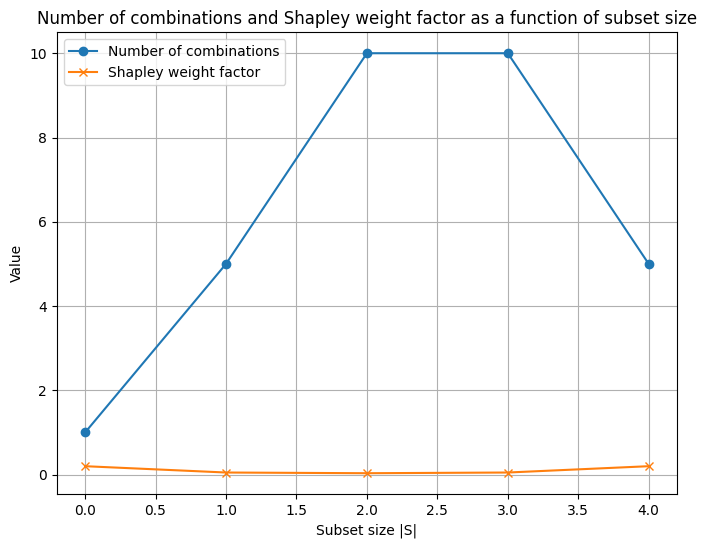

In [42]:
# YOUR CODE HERE
n = 5  # Total number of features
subset_sizes = list(range(n))  # Subset sizes from 0 to n-1

# Calculate the number of combinations and the weight factors for each subset size
combinations = [number_of_combinations(n, s) for s in subset_sizes]
weights = [shapley_weight_factor(n, s) for s in subset_sizes]

plt.figure(figsize=(8, 6))

# Plot the number of combinations
plt.plot(subset_sizes, combinations, label='Number of combinations', marker='o')

# Plot the Shapley weight factors
plt.plot(subset_sizes, weights, label='Shapley weight factor', marker='x')

# Add labels and title
plt.xlabel('Subset size |S|')
plt.ylabel('Value')
plt.title('Number of combinations and Shapley weight factor as a function of subset size')
plt.legend()
plt.grid(True)
plt.show()

***1.4 | Explain why the weighting factor is necessary. Think about what kind of bias we could expect if we did not weight the values.***

It accounts for the fact that not all subsets are equally likely to occur and thus not all provide the same marginal contribution. If we did not weight the values, we would be biasing the contribution of each feature to the model's output.

##### The 4 Axioms of Shapley Values

1. **Efficiency (or Full Distribution)**:
   - The total gain (or value) from cooperation must be distributed among all the players.
   - Explanation: The weighting factor ensures that all subsets are accounted for, and each feature’s contribution is factored into the overall total contribution, so nothing is over-counted or missed. Without this, the total sum of contributions could be skewed.

2. **Symmetry**:
   - If two features contribute equally to all possible subsets, they should receive the same Shapley value.
   - Explanation: The weighting factor helps to maintain symmetry by ensuring that no feature is favored due to the size or likelihood of specific subsets. Without weighting, features might seem more important simply because they appear in larger subsets, violating symmetry.

3. **Null Player**:
   - A feature that does not change the outcome of any subset (i.e., a null player) should have a Shapley value of 0.
   - Explanation: Without proper weighting, even a null feature might appear to have a contribution just by being part of larger subsets. The weighting factor corrects this by ensuring that a null feature does not contribute disproportionately.

4. **Additivity**:
   - If we have two separate games (or models) and the Shapley value for each is known, the Shapley value for the combined game should be the sum of the Shapley values of each game.
   - Explanation: The weighting factor preserves the consistency of contributions across different subsets and ensures that when contributions are summed across different games or models, they align with the individual contributions. Without the weighting, these values could become distorted, affecting additivity.

##### How the Weighting Factor Relates to the Axioms:

- **Efficiency**: The sum of all weighted contributions should equal the total contribution of all features, and the weighting factor guarantees this balance.
- **Symmetry**: The weighting ensures that features with equal influence across subsets are treated equally, preventing bias based on subset size.
- **Null Player**: Weighting ensures that a feature with no marginal contribution (null player) doesn’t mistakenly receive credit due to larger subset occurrences.
- **Additivity**: Proper weighting ensures that contributions across different subsets add up logically, maintaining consistency across different combinations of features.

### Section 2 | Calculating Shapley Values Using Monte Carlo Approximation

Although Shapley values are the ideal quantity for model explanations, there are two reasons we have to develop approximate methods to calculate them. Firstly, the computational cost (which we will explore in this section) is exponential with the number of features $n$, meaning if we want to find the attributions of images, text, or large tabular datasets, we will not be able to compute the values exactly. Secondly, we have seen that the exact Shapley value calculation requires a summation over all subsets of features. However, most ML models require inputs along each feature dimension to produce a prediction. This means we cannot simply feed in 4 features to a model that was trained to accept 8. In this case, we need to develop the idea of a baseline. A baseline is a value that can be fed into the model that represents "missingness", i.e., lack of input feature. If we find such a baseline, then we can flood the appropriate feature channels with the baseline to turn features off and effectively create a subset. The choice of baseline must be made very carefully.

We will look at the Monte Carlo approximation for calculating Shapley values. This method "turns features off" using a random baseline sampled from the dataset. Imagine a model that has been trained on a dataset with only 3 features. If we want to get rid of the effect of a single feature channel $j$, we could flood it with noise $q\sim \mathcal{N}(\mu, \sigma^2)$ from a normal distribution. In this case, the noise would not have the desired effect of a baseline since it will most definitely affect the model's output, i.e., $f_\theta(x_{j\to q_1}) \neq f_\theta(x_{j\to q_2})$. However, if we sample enough values $q_i$ from the normal distribution, the effects will cancel out and the expected value will converge $\mathbb{E}_{q\sim\mathcal{N}}[f_\theta(x_{j\to q})]=\text{constant}$. This idea is problematic for two reasons: firstly, sampling from noise implies that the features are not correlated since we are modeling them as independent, which for most cases is not true. Secondly, this assumption is prone to generate unrealistic samples outside of the model's training. 

Although sampling from a normal distribution is flawed, the idea of generating a baseline that does not affect the output from an expectation value is useful. The Monte Carlo approximation fixes the issues by sampling feature values from data instances themselves instead of random uncorrelated noise. The idea of baselines will be very important in this course. Remember that a baseline is a signal that we can send through our model, such that it effectively "turns off" the contribution of channels allowing us to create the subsets necessary to calculate Shapley values.

**2.1 | If we want to calculate the Shapley values exactly for a single feature of a single instance/row, how many calculations have to be performed? Provide your reasoning and answer for the case of $n=4$ features.**

In [43]:
# YOUR EXPLANATION HERE
n = 4
n_calculations = 2**(n-1)

print(n_calculations)

8


To calculate the exact Shapley value for a single feature of a single instance/row, we need to compute the **marginal contributions** of that feature across **all possible subsets** of the other features. 

Example: $$ n = 4 $$

If there are $ n = 4 $ features, and we want to calculate the Shapley value for a single feature (say feature 1), the number of subsets of the other 3 features is $ 2^{3} = 8 $. Thus, we need to perform 8 calculations to compute the Shapley value exactly for one feature.

These 8 calculations correspond to evaluating the model's output for the following subsets of the other three features:

- $ S = \emptyset $
- $ S = \{2\} $
- $ S = \{3\} $
- $ S = \{4\} $
- $ S = \{2, 3\} $
- $ S = \{2, 4\} $
- $ S = \{3, 4\} $
- $ S = \{2, 3, 4\} $

For each subset \( S \), we compute:

$$
f(S \cup \{1\}) - f(S)
$$

Therefore, **8 calculations** are required to compute the exact Shapley value for one feature when $ n = 4 $.

General Formula:
For \( n \) features, to calculate the exact Shapley value for one feature, the number of calculations needed is:

$$
2^{n-1}
$$

This grows exponentially with the number of features, making exact computation infeasible for large \( n \), which is why **Monte Carlo approximation** methods are used in practice.

**2.2 | Approximate Calculation of Shapley Values Using Monte Carlo** 

If the number of calculations necessary for a single Shapley value scales exponentially with the number of features, we require approximate methods. Code your own version of the Monte Carlo approximation, as discussed in the summary materials, to estimate the Shapley values of all four features for a single instance of the "bike_sharing_data" dataset and "bike_sharing_model" model. Compare your result with the output generated by the SHAP library.

Follow these steps:

1. Create a function that Implements the Monte Carlo approximation to estimate Shapley values.
2. Apply your implementation to estimate the Shapley values for all four features of a single instance from the "bike_sharing_data" dataset.
3. Compare your estimated Shapley values with those produced by the SHAP library.
4. Experiment with different numbers of Monte Carlo samples. Increase or decrease the number of samples and observe the changes in the estimated Shapley values.
5. Interpret your results, considering how the number of Monte Carlo samples affects the accuracy and stability of the Shapley value estimates.

By completing this exercise, you will gain an understanding of how the Monte Carlo approximation works, and how the effectiveness of baslines depends on the number of samples.

<img src="./static/shapley_monte_carlo.png" width="1000" alt="image description">

In [44]:
# Load the model and data
model = joblib.load('../models/bike_sharing_model.pkl')

# Load the data
data = pd.read_csv('../data/bike_sharing_data.csv')

In [45]:
import numpy as np
import pandas as pd

def monte_carlo_shapley_values(data: pd.DataFrame, model: object, M: int, sample_idx: int) -> list:
    """
    Calculate the Shapley values for all features using the Monte Carlo approximation.
    
    Parameters:
    data (pd.DataFrame): The dataset (each row is an instance, each column is a feature).
    model (sklearn-like model): The model for which we calculate Shapley values.
    M (int): The number of Monte Carlo simulations (i.e., the number of sampled coalitions).
    sample_idx (int): The index of the specific instance to explain in the dataset (the row index).
    
    Returns:
    dict: Dictionary of Shapley values for each feature.
    """
    
    # Step 1: Extract the instance (row) to explain and get the number of features
    x = data.iloc[sample_idx].copy()  # Extract the specific instance (row) we're explaining
    n_features = data.shape[1]  # Get the total number of features (columns) in the dataset
    feature_names = data.columns  # List of feature names (column names)
    
    # Initialize a dictionary to store the Shapley values (initially all 0)
    shapley_feature_values = {feature: 0 for feature in feature_names}

    # Step 2: Perform M Monte Carlo simulations to estimate Shapley values
    for _ in range(M):
        # Generate a random permutation of feature indices.
        # This simulates the random ordering of features for the coalition.
        permutation = np.random.permutation(n_features)  # A random shuffle of feature indices
        
        # Example: if n_features = 4, the permutation might be [2, 0, 3, 1].
        # This means feature 2 is added first, then feature 0, then feature 3, and finally feature 1.

        # Start by calculating the model prediction for the instance we are explaining.
        # This will be used to calculate the marginal contributions.
        previous_prediction = model.predict(data.iloc[[sample_idx]])[0]  # Initial prediction

        # Step 3: Now iterate through each feature in the permutation
        for i in range(n_features):
            # Create a baseline copy of a random instance from the dataset (this is the starting coalition).
            # We will update this by adding the true values from the original instance as we go through the permutation.
            x_permuted = data.iloc[np.random.randint(len(data))].copy() # The baseline coalition

            # permutation[:i+1] gives us the first i+1 features in the random permutation. 
            # We replace the values in x_permuted for these first i+1 features with the true values from x.
            # Example: If permutation = [2, 0, 3, 1], at i=0, we add feature 2, at i=1, we add features 2 and 0, and so on.
            for j in permutation[:i+1]:
                # For each feature j in the first i+1 elements of the permutation, replace its value in x_permuted
                # with the true value from x. 
                x_permuted[feature_names[j]] = x[feature_names[j]]  # Copy true feature value from x to x_permuted

            # After replacing i+1 features in x_permuted with the values from x, we now pass this updated instance
            # (x_permuted) to the model to get a prediction.

            # The model will make a prediction using x_permuted, which now has the true values of the first i+1 features.
            current_prediction = model.predict(x_permuted.to_frame().T)[0]

            # The marginal contribution of the (i+1)-th feature is calculated as the difference between the current prediction
            # and the previous prediction (before this feature was added).
            marginal = current_prediction - previous_prediction

            # We update previous_prediction to the current prediction, so that in the next iteration,
            # we can calculate the marginal contribution of the next feature in the permutation.
            previous_prediction = current_prediction

            # Add marginal contribution to the corresponding feature in the current permutation
            shapley_feature_values[feature_names[permutation[i]]] += marginal

    # Step 4: After M simulations, average the Shapley values for each feature
    for feature in shapley_feature_values:
        shapley_feature_values[feature] /= M

    # Return the estimated Shapley values for each feature
    return shapley_feature_values

# Example test of the function
M = 10  # Number of Monte Carlo simulations (for demo purposes, set to 1)
sample_idx = 0  # The instance to explain (row index 0)
shapley_values = monte_carlo_shapley_values(data, model, M, sample_idx)
print(shapley_values)

{'temp': -6.2348791823737235, 'feel_temp': 1.1578347237728646, 'humidity': -1.8781428799905406, 'windspeed': 6.955187338591392}


In [31]:
print(shapley_values)

{'temp': -8.981402441114643, 'feel_temp': 1.1149078678921698, 'humidity': 0.912989080166712, 'windspeed': 6.953505493055693}


In [52]:
# Wrap the sklearn pipeline model for SHAP compatibility
def shap_wrapper(model):
    def f(x):
        return model.predict(x)
    return f

# Create the SHAP Explainer with a masker
masker = shap.maskers.Independent(data)
explainer = shap.Explainer(shap_wrapper(model), masker=masker)

# Calculate the Shapley values using the Monte Carlo method and compare them with the SHAP values by taking the L2 norm of the difference
residuals = [] # to collect the differences between our monte carlo shapley values and the values from the SHAP library
n_itters = list(range(2, 500, 1)) # number of different Monte Carlo iterations to try
inst = 0 # instance to explain
x = data.iloc[inst:inst+1] # extract the instance to explain

print(x)

for n_itter in n_itters: # iterate over the number of iterations
    # YOUR CODE HERE
    shapley_values = monte_carlo_shapley_values(data, model, n_itter, inst)
    shap_values = explainer(x)  # SHAP Shapley values for the same instance
    residuals.append(np.linalg.norm(np.array(list(shapley_values.values())) - shap_values.values))

print(residuals)

    temp  feel_temp  humidity  windspeed
0  14.76      18.94      0.66        0.0
[80.54133293186344, 28.355205806675713, 35.65332343654369, 36.29526910021662, 24.422823003490343, 64.6819701109267, 18.729219104893385, 29.262206803423023, 21.817935425544007, 34.94001758336349, 45.20737605146067, 27.958668875994427, 20.035250366527453, 23.613984282538336, 37.78235881046488, 27.44281430617049, 23.819502396697157, 30.606865692955157, 20.925472191134656, 23.603080112855448, 24.676390925663746, 25.387690981733957, 24.199837960569223, 35.783767479993884, 17.752284997544667, 23.303876155164968, 21.49761173935347, 26.87854322729622, 32.365445415922295, 19.3667194278853, 21.92995522218177, 19.94483123384928, 23.564581454571233, 21.843923674501276, 20.827674973904724, 28.444607558317912, 20.486597605338172, 21.236696624585825, 27.81472327485995, 20.136814812779186, 21.021809920944467, 20.258083715309553, 21.041412787586697, 19.20867920084264, 27.350054378563573, 19.053956401882477, 24.89140324659

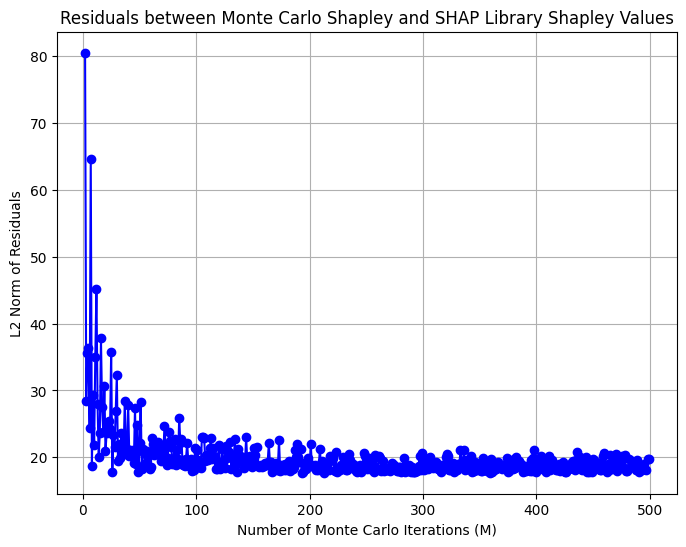

In [53]:
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.plot(range(2, 2 + len(residuals)), residuals, marker='o', color='b')
plt.xlabel('Number of Monte Carlo Iterations (M)')
plt.ylabel('L2 Norm of Residuals')
plt.title('Residuals between Monte Carlo Shapley and SHAP Library Shapley Values')
plt.grid(True)
plt.show()

In [ ]:
# YOUR EXPLANATION HERE

### Section 3 | Using the SHAP library to analyze the Titanic dataset  

In this section, we will use fast approximate methods to calculate Shapley values and analyze the Titanic dataset at different levels of granularity. By the end of this section, you should be able to interpret a wide variety of built-in SHAP plotting functions.

**3.1| Use the SHAP library to calculate the Shapley value for all features and instances of the Titianic dataset**

In [55]:
# Load the data
data = pd.read_csv('../data/titanic_data.csv')

# Load the model
model = joblib.load('../models/titanic_model.pkl')

In [61]:
# Calculate the SHAP values

# Convert the pandas DataFrame to XGBoost DMatrix
ddata = xgb.DMatrix(data)

# Initialize the SHAP explainer for XGBoost model
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(ddata)

**3.2 | Identify and Rank the Importance of Each Feature for the Model's Decisions, Plot and Discuss the Results**

Evaluating the importance of features is straightforward. Features with larger absolute Shapley values are more important for the model's decisions. Therefore, the feature's global importance is calculated as

$$
I_j = \frac{1}{n}\sum^n_{i=1}|\phi^{(i)}_j|.
$$

You can either calculate this manually and generate a bar plot, or use the SHAP built-in summary plotting function with `plot_type='bar'`.

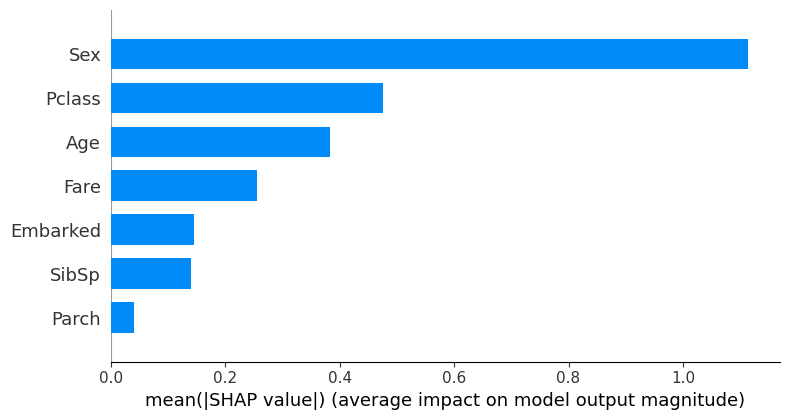

In [62]:
# Identify feature importance using the SHAP bar plot 

# Your CODE HERE
shap.summary_plot(shap_values, data, plot_type='bar')

The bar plot indicates that the factors contributing most to survival are Sex, Class, and Age. However, this information does not show the relationship between the predicted outcome and the feature values. For a more detailed view, we can use a SHAP summary (beeswarm) plot.

**3.3 | Use SHAPs built in summary/beeswarm plot and interpret the results**

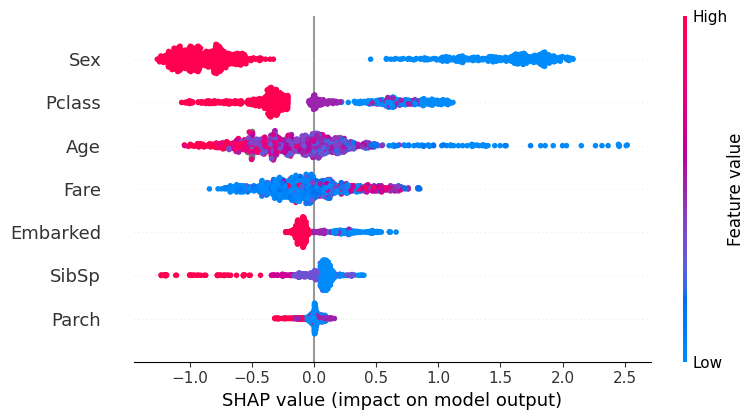

In [63]:
# Plot a bee swarm plot for the SHAP values

# YOUR CODE HERE
# shap summary beeswarm plot
shap.summary_plot(shap_values, data)

When interpreting the summary plot, consider the following points:

- **Vertical Axis**: Indicates feature importance, which corresponds to the same order as the bar plot.
- **Horizontal Position**: Shows whether the effect of a feature value is associated with a higher or lower prediction.
- **Color**: Represents whether that feature's value is high or low for that particular instance of the dataset.
- **Vertical Dispersion (Thickness)**: Is a proxy for the amount of feature interaction. Thick areas suggest a high interaction or dependence with other features.

In [ ]:
# YOUR EXPLANATION HERE

Key Elements:

1. **Vertical Axis (Features)**:
   - The vertical axis shows the **features** ranked by their overall importance. Features at the top of the plot (e.g., **Sex**) are more important in determining the model's predictions, while those at the bottom (e.g., **Parch**) are less important.

2. **Horizontal Axis (SHAP Values)**:
   - The horizontal axis shows the **SHAP value**, which represents the impact a feature has on the model’s output. SHAP values to the **right** (positive) indicate that the feature **increases the prediction**, while SHAP values to the **left** (negative) indicate that the feature **decreases the prediction**.
   - For a binary classification problem like survival prediction, a positive SHAP value might push the prediction towards the outcome "survived," while a negative SHAP value might push it toward "did not survive."

3. **Color (Feature Value)**:
   - The color of each point represents the **feature value**. Features are colored on a spectrum from **blue** (low value) to **red** (high value).
   - For example, for the **Sex** feature:
     - Blue indicates a lower value (which likely corresponds to "male").
     - Red indicates a higher value (which likely corresponds to "female").

4. **Vertical Dispersion (Thickness/Spread)**:
   - The **thickness** of the points for each feature shows the **distribution of SHAP values** for that feature across all predictions in the dataset.
   - A wider spread means that the feature has a **varying impact** across different predictions, indicating that it interacts with other features in complex ways. Thinner clusters mean the feature has a more consistent impact across predictions.

Feature-by-Feature Interpretation:

1. **Sex**:
   - This is the most important feature in the model.
   - **Blue points** (low values, likely males) generally have **negative SHAP values**, meaning that being male reduces the likelihood of survival in the model's prediction.
   - **Red points** (high values, likely females) have **positive SHAP values**, meaning that being female increases the likelihood of survival in the model's prediction.

2. **Pclass**:
   - This feature also has a significant impact.
   - **Blue points** (low values, likely higher social class) push the prediction towards survival (positive SHAP values).
   - **Red points** (high values, likely lower social class) push the prediction towards lower survival rates (negative SHAP values).

3. **Age**:
   - The impact of age is more complex, with both positive and negative SHAP values.
   - **Blue points** (younger individuals) tend to have slightly higher SHAP values, suggesting that younger age increases the chance of survival.
   - **Red points** (older individuals) tend to have negative SHAP values, meaning older age decreases the chance of survival.

4. **Fare**:
   - **Blue points** (low fare) have **negative SHAP values**, meaning paying a lower fare is associated with a lower chance of survival.
   - **Red points** (high fare) have **positive SHAP values**, meaning paying a higher fare is associated with an increased chance of survival.

5. **Embarked**:
   - There seems to be a clearer separation for this feature, where some embarkation points (colored red) have a more positive impact on survival, while others (colored blue) reduce the likelihood of survival.

6. **SibSp**:
   - The impact of siblings/spouses on board is small but can have both positive and negative effects depending on the value.

7. **Parch**:
   - The feature has the least impact overall, with a minor influence on the model's predictions, though it shows a similar behavior to **SibSp**.

**3.4 | Compare a PDP plot for `Age` with a SHAP dependancy plot. What additional information do we gain?**  

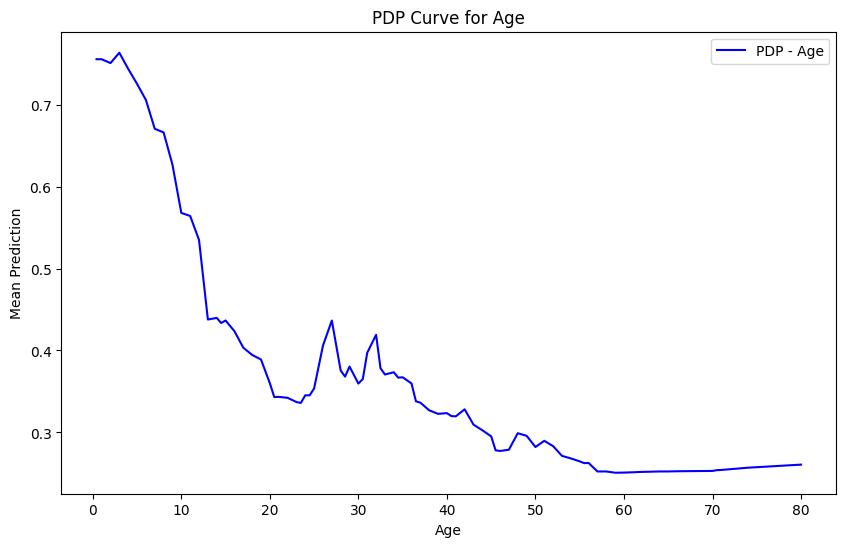

In [66]:
# Calculate the PDP curve for a single feature

# Select the feature to compare
feature_name = 'Age'

# Prepare data
data_sorted = data.sort_values(by=feature_name)  # Order the rows of the data according to the value of the target feature
feature_values = data_sorted[feature_name]  # Get the target feature values
feature_values_unique = feature_values.unique()  # Get the unique values of the target feature
xax = feature_values_unique.copy()  # These are the x-axis values for the PDP curve

# Calculate PDP curve
pdp_curve = []
for val in feature_values_unique:
    # Create a copy of the data and set all 'Age' values to the current 'val'
    data_copy = data_sorted.copy()
    data_copy[feature_name] = val
    # Calculate the mean prediction with the modified 'Age'
    ddata = xgb.DMatrix(data_copy)
    pdp_curve.append(np.mean(model.predict(ddata)))

# Plot PDP curve
plt.figure(figsize=(10, 6))
plt.plot(xax, pdp_curve, label='PDP - Age', color='blue')
plt.title('PDP Curve for Age')
plt.xlabel('Age')
plt.ylabel('Mean Prediction')
plt.legend()
plt.show()

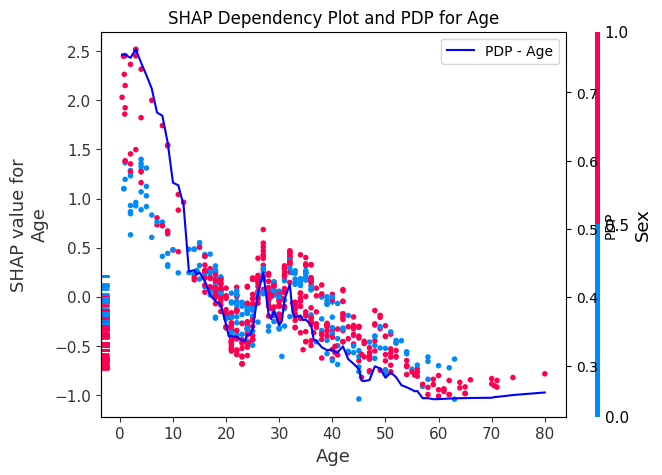

In [68]:
# Plot SHAP values and PDP curve on the same plot but with different y-axes

# YOUR CODE HERE
# Plot SHAP dependency plot for Age
shap.dependence_plot(feature_name, shap_values.values, data, show=False)

# Overlay PDP curve on the same plot with different y-axes
plt.twinx()  # Create a twin y-axis to overlay the PDP
plt.plot(xax, pdp_curve, label='PDP - Age', color='blue')
plt.ylabel('PDP')
plt.title(f"SHAP Dependency Plot and PDP for {feature_name}")
plt.legend()
plt.show()

In [ ]:
# YOUR EXPLANATION HERE

**3.5 | Plot a SHAP feature dependence plot for 'Age' with interaction visualization for the passengers' Sex. Interpret the results**

In [ ]:
# Plot a SHAP feature dependence plot with interaction visualization

# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE

**3.6 | Remove all the individual effects of the features and plot only the pure interaction between 'Age' and 'Class'**  

Formerly the SHAP library will is calculate

$$
\phi_{i, j}=\sum_{S \subseteq \backslash\{i, j\}} \frac{|S|!(M-|S|-2)!}{2(M-1)!} \delta_{i j}(S),
$$

where $i\neq j$, and

$$
\delta_{i j}(S)=\hat{f}_x(S \cup\{i, j\})-\hat{f}_x(S \cup\{i\})-\hat{f}_x(S \cup\{j\})+\hat{f}_x(S).
$$

In other words we subtract the main effects by accounting for individual feature effects.

In [ ]:
# Calculate the pure SHAP interaction values (One M times M matrix for each instance)

# YOUR CODE HERE

In [ ]:
#Plot the pure SHAP interaction values for the Age and Sex features

# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE

**3.7 | Local Shapley Explanations**

Plot a waterfall plot for three individuals: the one most likely to survive according to the model, the one least likely to survive, and an average passenger. Interpret the results.

In [ ]:
# YOUR CODE HERE

Each waterfall plot represents a single point on the beeswarm plot. These plots provide local explanations on a per-instance basis, allowing us to precisely determine the factors contributing to or detracting from an individual's survival probability. The individual most likely to survive is a high-paying, middle-aged, first-class female passenger, while the lowest survival probability is assigned to a low-paying, elderly, third-class male passenger.

### Section 4 | Determine the decision making process of the mystery model  

Here you should have developed all the tools necessary to quickly identify the mechanism of decision for this simple model.  

In [ ]:
# Load the mystery data 
X = pd.read_csv('../data/mystery_data.csv')

# Load the mystery model
model = joblib.load('../models/mystery_model.pkl')

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE